In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from astropy import units as u
from astropy import constants as const
from scipy.integrate import solve_bvp

In [2]:
# Global Variables
GM2 =((const.G)*(1E9*u.solMass)).decompose()
r_s = (1000*u.pc).decompose() # critical radius
V_c = np.sqrt(GM2 / r_s) # Thermal Gas Circular Velocity at critical radius
U_B0 = ((1E-15)*(u.erg/(u.cm**3))).decompose() # Constant Magnetic Energy Density in the Galaxy
rho_s = 1*(1.67E-27)*(u.kg/(u.m**3)) # Density at critical radius
R_CT = 2 # Ratio between Cosmic Ray Pressure and Thermal Gas Pressu}re
R_Trho = (50*(u.Pa /(u.kg/(u.m**3)))).decompose() # Ratio between Thermal Gas Pressure and density
R_Crho = (75*(u.Pa /(u.kg/(u.m**3)))).decompose() # Ration between Cosmic Ray Pressure and density
v_A0_2 = ((8*np.pi*U_B0) /(4*np.pi*rho_s)).decompose() # Alfven Velocity at critical radius

In [12]:
# Defining functions

c_s = (34489)*((u.m)/(u.s))

# c^2_s
def c2_s(y, v, theta_c, x, c_s):
    a = R_Crho*(theta_c/y)
    b = 5/3 + (2/3)*\
    (v*c_s + v_eff2(x, y, v, c_s))*\
    (v*c_s - (2/3)*(np.sqrt(v_A0_2)/((x**2)*(np.sqrt(y)))))/(v*c_s*v_eff2(x, y, v, c_s))
    return a*b

# v_eff (original v + v_A)
def v_eff2(x, y, v, c_s):
    v1 = c_s * v
    v_A = np.sqrt(v_A0_2) / ((x**2)*np.sqrt(y))
    return v1 + v_A

# du/dx (original dv/dr)
def dv2dx(x, v, c_s):
    #print(v, (V_c/c_s), (v/x))
    num = 2*v - ((V_c/c_s)**2)*(v/x)
    dem = x*(v**2 - 1)
    return num/dem

# dtheta_c/dx (original dP_c/dr)
def dtheta_c2dx(y, theta_c, v, dy, c_s):
    a = theta_c/y
    b = (v*c_s + v_eff2(x, y, v, c_s))/(2*v_eff2(x, y, v, c_s))
    c = dy
    return a*b*c

# dtheta/dx (original dP/dr)
def dtheta2dx(theta, theta_c, y, v, dy, c_s):
    a = (5*theta)/(3*y)
    b = ((4*theta_c)/(9*y))*R_CT
    c = ((np.sqrt(v_A0_2)/((x**2)*np.sqrt(y)))*(v*c_s + v_eff2(x, y, v, c_s)))/(v*c_s*v_eff2(x, y, v, c_s))
    return (a - b*c)*dy

# dy/dx (original drho/dr)
def dy2dx(x, y, v, theta, theta_c, c_s):
    a = 1/((v**2)*(c_s**2))
    
    a1 = theta_c/y
    b1 = (v*c_s + v_eff2(x, y, v, c_s))/(2*v_eff2(x, y, v, c_s))
    
    a2 = (5*theta)/(3*y)
    b2 = ((4*theta_c)/(9*y))*R_CT
    c2 = ((np.sqrt(v_A0_2)/((x**2)*np.sqrt(y)))*(v*c_s + v_eff2(x, y, v, c_s)))/(v*c_s*v_eff2(x, y, v, c_s))
    
    b = R_Trho*a*(a2 - b2*c2)
    c = R_Crho*a*(a1*b1)
    d = a*((y*(V_c**2))/(x**2))
    e = (2*y)/x
    return (d - e)/(1 - b - c)



In [13]:
# Iterations & Integrations
Iteration = 100 #resolution (can change for better result)

#Initial value for x and step counts
x02 = 1
x_max2 = 10

X2 = np.linspace(x02, x_max2, Iteration) #range of x-axis that we are integrating
x_step2 = (x_max2 - x02)/Iteration

# Initial values for all functions (can change to adjust whenever)
v = 1.1 # Velocity
y = 1 # Density
theta = 1 # Thermal Gas Pressure
theta_c = 1 # Cosmic Ray Pressure


# Empty Arrrays for Appending All Unknown Functions
V2 = np.array([])
Y = np.array([])
Theta = np.array([])
Theta_C = np.array([])
C_s = np.array([])*((u.m)/(u.s))

# Integration Process
for x in X2:    
    kv1 = x_step2 * dv2dx(x, v, c_s)
    ky1 = x_step2 * dy2dx(x, y, v, theta, theta_c, c_s)
    ktheta_c1 = x_step2 * dtheta_c2dx(y, theta_c, v, dy2dx(x, y, v, theta, theta_c, c_s), c_s)
    ktheta1 = x_step2 * dtheta2dx(theta, theta_c, y, v, dy2dx(x, y, v, theta, theta_c, c_s), c_s)
    
    kv2 = x_step2 * dv2dx(x+0.5*x_step2, v+0.5*kv1, c_s)
    ky2 = x_step2 * dy2dx(x+0.5*x_step2, y+0.5*ky1, v+0.5*kv1, theta+0.5*ktheta1, theta_c+0.5*ktheta_c1, c_s)
    ktheta_c2 = x_step2 * dtheta_c2dx(y+0.5*ky1, theta_c+0.5*ktheta_c1, v+0.5*kv1,
                                    dy2dx(x+0.5*x_step2, y+0.5*ky1, v+0.5*kv1, theta+0.5*ktheta1, 
                                         theta_c+0.5*ktheta_c1, c_s), c_s)
    ktheta2 = x_step2 * dtheta2dx(theta+0.5*ktheta1, theta_c+0.5*ktheta_c1, y+0.5*ky1, v+0.5*kv1,
                                dy2dx(x+0.5*x_step2, y+0.5*ky1, v+0.5*kv1, theta+0.5*ktheta1, 
                                         theta_c+0.5*ktheta_c1, c_s), c_s)
    
    kv3 = x_step2 * dv2dx(x+0.5*x_step2, v+0.5*kv2, c_s)
    ky3 = x_step2 * dy2dx(x+0.5*x_step2, y+0.5*ky2, v+0.5*kv2, theta+0.5*ktheta2, theta_c+0.5*ktheta_c2, c_s)
    ktheta_c3 = x_step2 * dtheta_c2dx(y+0.5*ky2, theta_c+0.5*ktheta_c2, v+0.5*kv2,
                                    dy2dx(x+0.5*x_step2, y+0.5*ky2, v+0.5*kv2, theta+0.5*ktheta2,
                                         theta_c+0.5*ktheta_c2, c_s), c_s)
    ktheta3 = x_step2 * dtheta2dx(theta+0.5*ktheta2, theta_c+0.5*ktheta_c2, y+0.5*ky2, v+0.5*kv2,
                                dy2dx(x+0.5*x_step2, y+0.5*ky2, v+0.5*kv2, theta+0.5*ktheta2,
                                         theta_c+0.5*ktheta_c2, c_s), c_s)
    
    kv4 = x_step2 * dv2dx(x+x_step2, v+kv3, c_s)
    ky4 = x_step2 * dy2dx(x+x_step2, y+ky3, v+kv3, theta+ktheta3, theta_c+ktheta_c3, c_s)
    ktheta_c4 = x_step2 * dtheta_c2dx(y+ky3, theta_c+ktheta_c3, v+kv3,
                                    dy2dx(x+x_step2, y+ky3, v+kv3, theta+ktheta3, theta_c+ktheta_c3, c_s), c_s)
    ktheta4 = x_step2 * dtheta2dx(theta+ktheta3, theta_c+ktheta_c3, y+ky3, v+kv3,
                                dy2dx(x+x_step2, y+ky3, v+kv3, theta+ktheta3, theta_c+ktheta_c3, c_s), c_s)
    
    v += (kv1 +2*kv2 + 2*kv3 + kv4)/6
    y += (ky1 +2*ky2 + 2*ky3 + ky4)/6
    theta_c += (ktheta_c1 + 2*ktheta_c2 + 2*ktheta_c3 + ktheta_c4)/6
    theta += (ktheta1 + 2*ktheta2 + 2*ktheta3 + ktheta4)/6
    
    c_s = np.sqrt(c2_s(y, v, theta_c, x, c_s))
    C_s = np.append(C_s, c_s)
    
    V2 = np.append(V2, v)
    Y = np.append(Y, y)
    Theta_C = np.append(Theta_C, theta_c)
    Theta = np.append(Theta, theta)
    print(V2)

/Users/stevenhsueh/opt/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[0.94828062]
[0.94828062        nan]
[0.94828062        nan        nan]
[0.94828062        nan        nan        nan]
[0.94828062        nan        nan        nan        nan]
[0.94828062        nan        nan        nan        nan        nan]
[0.94828062        nan        nan        nan        nan        nan
        nan]
[0.94828062        nan        nan        nan        nan        nan
        nan        nan]
[0.94828062        nan        nan        nan        nan        nan
        nan        nan        nan]
[0.94828062        nan        nan        nan        nan        nan
        nan        nan        nan        nan]
[0.94828062        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan]
[0.94828062        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
[0.94828062        nan        nan        nan        nan        nan
        nan        nan        nan        nan 

In [19]:
0.94828062*(u.m/u.s)

s = np.sqrt(c2_s(y, v, theta_c, x, 0.94828062*(u.m/u.s)))
print(s, y, v, theta_c, x)

nan m / s nan nan nan 10.0


Text(0.5, 1.0, 'Outflow Solution for v(r)')

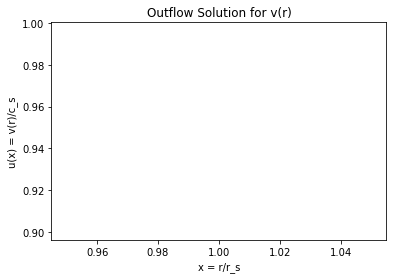

In [17]:
plt.plot(X2, V2)
plt.xlabel("x = r/r_s")
plt.ylabel("u(x) = v(r)/c_s")
plt.title("Outflow Solution for v(r)")

Text(0.5, 1.0, 'Outflow Solution for log(rho(r))')

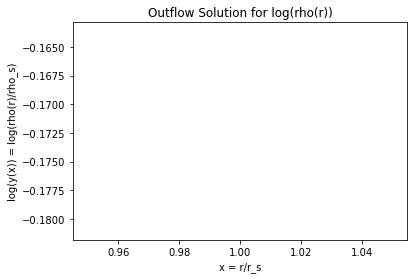

In [8]:
plt.plot(X2, np.log(Y))
plt.xlabel("x = r/r_s")
plt.ylabel("log(y(x)) = log(rho(r)/rho_s)")
plt.title("Outflow Solution for log(rho(r))")

Text(0.5, 1.0, 'Outflow Solution for log(P(r))')

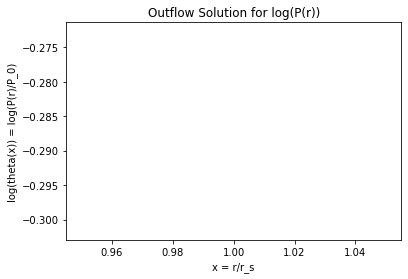

In [9]:
plt.plot(X2, np.log(Theta))
plt.xlabel("x = r/r_s")
plt.ylabel("log(theta(x)) = log(P(r)/P_0)")
plt.title("Outflow Solution for log(P(r))")

Text(0.5, 1.0, 'Outflow Solution for log(P_C(r))')

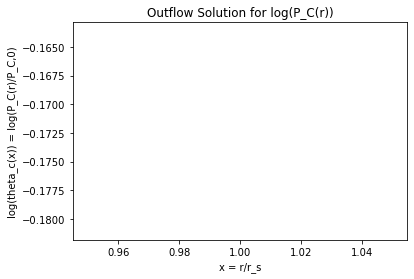

In [10]:
plt.plot(X2, np.log(Theta_C))
plt.xlabel("x = r/r_s")
plt.ylabel("log(theta_c(x)) = log(P_C(r)/P_C,0)")
plt.title("Outflow Solution for log(P_C(r))")